# INF-SR: LabExercise Naive Bayes Classifier

## Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import nltk
import os
import wget
import sys

def sr_download(file):
    if not os.path.isfile(file):
        url = "https://staff.fnwi.uva.nl/r.vandenboomgaard/downloads/" + file
        print('[sr]',f'Downloading file {file} for statistical reasoning course')
        wget.download(url)
    else:
        print('[sr]',f'data {file} already downloaded')
        
sr_download('spamham.csv')
sr_download('biometrie2014.csv')

nltk.download('punkt')
nltk.download('stopwords')

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

print(f"Using Python version {sys.version}")
print(f"Using nltk version {nltk.__version__}")
if nltk.__version__ < "3.5": 
    print("Please install nltk version 3.8.1 in case you encounter any problems in grading exercises using this package")



[sr] data spamham.csv already downloaded
[sr] data biometrie2014.csv already downloaded
Using Python version 3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]
Using nltk version 3.4.5
Please install nltk version 3.8.1 in case you encounter any problems in grading exercises using this package


[nltk_data] Downloading package punkt to /home/sasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Spam Classification

### Theory

In this subsection we will look at a naive Bayes classifier for text messages. First a text message is reduced to a list of words (out of a fixed length dictionary of $n$ words). The occurrence of a word (with index $j$ in the dictionary) in a text message is indicated with the boolean random variable $W_i$ for $i=1,\ldots,n$. A text message is classified either as 'spam' or 'ham' (non spam). The class is indicated with the random varianble $Y$ that is also a boolean random variable ($Y=1$ for 'spam' and $Y=0$ for 'ham').

The Bayes classifier then is:
$$\text{classify}(w_1, \ldots, w_n) = \arg\max_{Y=y} P(Y=y \bigm| W_1=w_1, \ldots, W_n=w_n) $$

Rewrite the classifier using the naive Bayes assumption and express the classifier in terms of the class conditional probabilities $P(W_i=w_i\bigm|Y=y)$ and a priori probabilities $P(Y=y)$.

$$\text{classify}(w_1,\ldots,w_n) = \arg\max_y P(Y=y) \prod_{i=1}^{n} P(W_i=w_i\bigm| Y=y)$$ 

### The Data Set

In this exercise we will analyze a data set with short texts labeled as either spam or ham (not spam). The goal is to develop a classifier that is able to do the classification given only the text.

#### Preparing the Data Set

For reading and displaying the data we will use the ``csv`` Python module (note that Numpy can read csv files but it is hard to deal with variable length strings in Numpy). For processing the text messages we will use the ``nltk`` module. Some methods from natural language processing are needed to deal with the text messages. These methods allow us to represent the text messages as numerical information to be used in numerical machine learning techniques (the naive Bayesian classifier in our case).

In [2]:
file = open('spamham.csv')
reader = csv.reader(file, delimiter='\t')
data = [row for row in reader]
s = f'| |**class**| **text**|\n| -- | :--- | :--- |\n'
for i in range(10):
    s += f'| {i} |{data[i][0]}|{data[i][1]}|\n'
printmd(s)

| |**class**| **text**|
| -- | :--- | :--- |
| 0 |ham|Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...|
| 1 |ham|Ok lar... Joking wif u oni...|
| 2 |spam|Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's|
| 3 |ham|U dun say so early hor... U c already then say...|
| 4 |ham|Nah I don't think he goes to usf, he lives around here though|
| 5 |spam|FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv|
| 6 |ham|Even my brother is not like to speak with me. They treat me like aids patent.|
| 7 |ham|As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune|
| 8 |spam|WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.|
| 9 |spam|Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030|


Note that ``data`` is not a numpy array but a list of lists. Instead of using ``data[k,0]`` to get at the label in the k-th row we have to write ``data[k][0]``.

Preparing the dataset is done by:
- making all characters lowercase, 
- splitting the text into words and omitting punctuation,
- removing stopwords (the commonly used words like 'the' because they are not characteristic for either spam or ham messages), and
- stemming (i.e. replacing a word by its 'stem', i.e. the wordt 'go', 'going' and 'goes' are all replaced with the word 'go')

We first write the function ``prepare_text`` that processes one text message string and returns a list of of strings each string representing a word in the message.


In [3]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

def prepare_text(text, stopwords, stemmer):
    text = text.lower()
    words = nltk.tokenize.word_tokenize(text)
    words = [w for w in words if len(w)>2]
    words = [w for w in words if w not in stopwords]
    words = [stemmer.stem(w) for w in words]
    return words
    
# as an example:
k = 100
print("orginal text:\t", data[k][1], sep='')
print("prepared text:\t", end='')
for w in prepare_text(data[k][1], stopwords, stemmer):
    print(w, end=' ')


orginal text:	Please don't text me anymore. I have nothing else to say.
prepared text:	pleas n't text anymor noth els say 

Next, we will join all prepared text strings from all messages, and find the unique words to form the set of words we will work with to represent a message. Note that using a Python ``set`` to keep track of the words in all messages we make sure that all words in the final set are unique. The resulting set is turned into a list again to make indexing simple.

In [4]:
allwords = set()
for label, text in data:
    allwords = allwords.union(set(prepare_text(text, stopwords, stemmer)))
    
allwords = list(allwords) # make it a list to allow indexing

The set of all words is the dictionary that will be used to represent a message text in a numerical way. For each of the words in the dictionary we will score how many times that word is in the text. We'll make a data array ``X`` such that ``X[i,j]`` is the number of times that the j-th word in the dictionary is in the i-th text. At the same time we make the target vector ``t`` such ``t[i]=1`` in case the i-th text is spam and ``t=0`` for ham. 

In [5]:
# first write the function words_to_x that takes a list of words in the text
# (i.e. the words in it, so after the text is filtered through the function prepare_text)

# words: list of words as returned from prepare_text
# allwords: list of all words in the dictionary
# x: array of integers such that x[j] equals the number
#    of times that word allwords[j] is present in the list words
def words_to_x(words, allwords):
    x = [words.count(word) for word in allwords]
    return x


def make_X_y(data, allwords, stopwords, stemmer):
    # data: data in the form of a list of tuples (label, text)
    # allwords: allwords in entire data set (prepared by te)
    m = len(data) # no of texts
    n = len(allwords) # no of words in dictionary
    X = np.zeros((m,n), dtype=int) # numerical data matrix X[i,j] = no of times word j occurs in text i
    y = np.zeros(m, dtype=int) # numerical target vector y[i] = 0 == ham, y[i]=1 == spam

    for i in range(m):
        y[i] = (data[i][0] == 'spam')
        X[i] = words_to_x(prepare_text(data[i][1], stopwords, stemmer), allwords)

    # X: data matrix X[i,j] = no of times word j occurs in text i
    # y: target vector y[i]=1 for spam and y[i]=0 for ham
    return X, y


# Note: this can take some time...
X_total, y_total = make_X_y(data, allwords, stopwords, stemmer)

Make an array `word_count` such that `word_count[j]` equals the number of times `allwords[j]` is present *at least once* in all text messages (either spam or not). In calculating this `word_count` array only the `X` array can be used. What is the most frequently used word? And how many times has it been used?

In [6]:
# make the array word_count
word_count = np.sum(X_total > 0, 0)
j_max_count = np.argmax(word_count)
word_max_count = allwords[j_max_count]
print(f'Most frequently used word "{allwords[j_max_count]}" is used {word_count[j_max_count]} times in {len(allwords)} messages')

Most frequently used word "..." is used 772 times in 8079 messages


In [7]:
# We'll make the array j_sorted giving the indices of the sorted word_count array (in decreasing order)
j_sorted = np.argsort(word_count)[::-1]
print(word_count[j_sorted])

[772 590 418 ...   1   1   1]


What is the message (and its label) containing the maximal number of the same word? And which word is that? (not an exercise only a demo).

In [8]:
msg_idxs, word_idxs = np.nonzero(X_total==X_total.max())
message_idx_max_freq = msg_idxs[0]
word_idx_max_freq = word_idxs[0]
print(f"In the '{data[message_idx_max_freq][0]}' message {message_idx_max_freq} word '{allwords[word_idx_max_freq]}'", end=" ")
print(f"occurs {X_total[message_idx_max_freq, word_idx_max_freq]} times, the message is:")
printmd(data[message_idx_max_freq][1])

In the 'ham' message 3017 word 'happi' occurs 15 times, the message is:


&lt;#&gt;  is fast approaching. So, Wish u a very Happy New Year Happy Sankranti Happy republic day Happy Valentines Day Happy Shivratri Happy Ugadi Happy Fools day Happy May Day Happy Independence Day, Happy Friendship,Mother,Father,Teachers,Childrens Day, &amp; HAPPY BIRTHDAY 4 U. Happy Ganesh festival Happy Dasara Happy Diwali Happy Christmas  &lt;#&gt;  Good Mornings Afternoons, Evenings Nights. RememberI AM the first to WISHING U ALL THESE...your's Raj

#### Making the Train and Test Set

In all machine learning applications, it is important to make a distinction between training and test set. The easy way would be to make the training set out of the first examples in your data set and reserve the rest for the test set. But then you run the risk that the first examples might not be a faithful representation of the entire population (remember Trump doing that, interpreting the first poll results as being representative for the entire state? Obviously he didn't follow any course on statistics while he even had 'the best education'). Therefore we shuffle the rows in the data set first (well actually we only shuffle the indices...).

In [9]:
np.random.seed(42)
m = len(data)
random_idx = np.arange(m)
np.random.shuffle(random_idx) # note that shuffling is done 'inline'
m_train = int(0.7*m) # we reserve 70% for learning
m_test = m - m_train # and 30% for testing
train_idx = random_idx[:m_train]
X_train = X_total[train_idx,:]
y_train = y_total[train_idx]
test_idx = random_idx[m_train:]
X_test = X_total[test_idx]
y_test = y_total[test_idx]
print("m:", m)
print("train_idx", train_idx)
print("len train_idx:", len(train_idx))
print("X train:",X_train)
print("y train: ",y_train)

m: 5572
train_idx [3245  944 1044 ... 4174 5429 3811]
len train_idx: 3900
X train: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y train:  [0 0 0 ... 0 0 0]


Please note that by definition every word from the ```allwords``` list are represented in the total set of messages. But that is NOT true for the training set (see code in the cell below). **Please be aware that this fact has consequences on how to estimate the class conditional word probabilities.**

In [10]:
print(X_total.sum(axis=0).min())
print(X_train.sum(axis=0).min())

1
0


### Estimating the Probabilities

From the data matrix $X$ and target vector $y$ we now have to calculate the a priori probabilities
$P(Y=y)$ for $y=0$ (ham) and $y=1$ (spam) and the conditional word probabilities $P(W_j=w|Y=y)$ where $W_j=1$ if the j-th word from the array ``allwords`` is present in a message and $W_j=0$ if it isn't present. **Please note that we will not make use of the fact that a word might be present more than once in a message.**

We will encode the a priori probabilities in the 2 element array `Py` where `Py[j]` is $P(Y=j)$. The conditional word probabilities are encoded in the two dimensional array `Pwgy` such that `Pwgy[i,j]` is equal to the probability $P(W_i=1|Y=j)$. In the code cell below you have to estimate all these probabilities. **Please refer to the section on [Estimators for Distribution Parameters](https://staff.fnwi.uva.nl/r.vandenboomgaard/MachineLearning/LectureNotes/ProbabilityStatistics/probEstimation.html).** (Implement the estimator using the "add 1 Laplace" smoothing).

In [11]:
# Write the code to calculate the ``Py`` and ``Pwgy`` arrays
Py = np.zeros(2, dtype=float)
Pwgy = np.zeros((len(allwords),2), dtype=float)
for i in range(2):
    Py[i] = np.sum(y_train == i) / len(y_train)

    # In how many spam or ham messages the word occurs
    word_count = np.sum((X_train > 0)[y_train == i], 0)

    # How many spam or ham messages are in the training set
    message_count = sum(y_train == i)

    Pwgy[:,i] = (word_count + 1) / (message_count + 2)

Given the estimated probabilities, let's see the 10 most probable spam and ham words:

In [12]:
idx_Pwg1 = np.argsort(Pwgy[:,1])[::-1]
print("Most frequent spam words")
print("\tProbability\tWord")
print("--------------------------------------")
for i in range(10):
    print(f'{i}\t{Pwgy[idx_Pwg1[i],1]:#1.5f}\t\t{allwords[idx_Pwg1[i]]}')
print("")
idx_Pwg0 = np.argsort(Pwgy[:,0])[::-1]
print("Most frequent ham words")
print("\tProbability\tWord")
print("--------------------------------------")
for i in range(10):
    print(f'{i}\t{Pwgy[idx_Pwg0[i],0]:#1.5f}\t\t{allwords[idx_Pwg0[i]]}')

Most frequent spam words
	Probability	Word
--------------------------------------
0	0.45038		call
1	0.21947		txt
2	0.21374		free
3	0.16985		claim
4	0.15840		mobil
5	0.15649		text
6	0.12977		prize
7	0.12023		stop
8	0.12023		repli
9	0.11260		get

Most frequent ham words
	Probability	Word
--------------------------------------
0	0.15503		...
1	0.07189		get
2	0.05769		n't
3	0.05621		come
4	0.05414		call
5	0.05030		got
6	0.04763		know
7	0.04704		like
8	0.04615		'll
9	0.04379		time


### Defining the Classifier

In the code cell below write the code for the ``spam_classifier`` function. The input is a vector (array) ``x`` where ``x[j]`` is the number of times word ``j`` from the dictionary occurs in a text. Argument ``Pwgy`` encodes all the class conditional probabilities and ``Py`` the a priori probabilities. The function should return a tuple ``(y, Pygt)`` where ``Pygt`` equals $P(Y=y\bigm|W_1=w_1,\ldots,W_n=w_n)$ for the value of $y$ that maximizes this probability. **Please note that ``x[i]`` equals the number of occurrences of the i-th word in the dictionary, whereas $w_i$ is 1 in case the i-th word occurs at least once in the message.**

In [30]:
def spam_classifier(x, Pwgy, Py):
    Pygt = np.zeros(2, dtype=float)
    x = np.array(x)

    for i in range(2):
        Pygt[i] = np.log(Py[i]) + np.sum(np.log(Pwgy[x > 0, i])) + np.sum(np.log(1 - Pwgy[x == 0, i]))

    Pygt = np.exp(Pygt - np.max(Pygt))
    Pygt /= np.sum(Pygt)  # Normalize

    y = np.argmax(Pygt)

    return (y, Pygt[y])

The code in the next cell allows you to test your classifier on a random text from the entire data set.

In [31]:
k = np.random.randint(0, len(data))
print(data[k])
y, p = spam_classifier(words_to_x(prepare_text(data[k][1], stopwords, stemmer), allwords), Pwgy, Py)
print(y, p)

['ham', 'When are you going to ride your bike?']
0 0.9999999998631979


In [32]:
# The assert statement in this cell uses your classifier on 10 examples.
# The numeric array in the assert statement is what the reference implementation returns on \
# the given set of examples (don't change the seed...)
np.random.seed(42**2)
N = 10
ks = np.random.randint(0, len(data), size=N)
results = np.zeros((N,2))
for i, k in enumerate(ks):
    y, p = spam_classifier(words_to_x(prepare_text(data[k][1], stopwords, stemmer), allwords), Pwgy, Py)
    results[i] = (y, p)

print(results)

assert np.allclose(results, np.array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.99999949],
       [0.        , 1.        ],
       [0.        , 1.        ]]))

[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.99999971]
 [0.         1.        ]
 [0.         1.        ]]


### Testing the Classifier

Next run your classifier over the entire test set and calculate the accuracy of the classifier as the percentage of correctly classified examples from the test set.

In [33]:
def calculate_accuracy(X_test, y_test, classifier, Pwgy, Py):
    # the function should return the accurracy as a percentage
    correct = 0
    for i in range(len(y_test)):
        if y_test[i] == classifier(X_test[i], Pwgy, Py)[0]:
            correct += 1

    return (correct / len(y_test) * 100)

print('Accuracy = ', calculate_accuracy(X_test, y_test, spam_classifier, Pwgy, Py))

Accuracy =  96.77033492822966


An accuracy of 96% is quite good for such a simple classifier. In todays practice spam classifiers need to be a lot better. In general, spam emails make out for more than 90% of all emails and in such cases way too much spam would not be detected and more seriously, way too much ham would be classified as spam and never show up in your mailbox.
To improve performance one can 
- tweak the parameters of the classifier being used,
- use another better classifier,
- consider more and other features to characterize a text message, or
- use a larger dataset to learn from.

## Gender Classification

### Theory

The Bayes classifier based on a zero-one loss function classifies a person with given $L$, $W$ and $S$ as $G=0$ (male), $G=1$ (female) or $G=2$ (X or other):
$$\text{classify}(l, w, s) = \arg\max_g P(G=g\bigm| L=l, W=w, S=s)$$
The three measurements are real valued and assumed to be values from independent class conditional normal distributions.

In the homework exercise you have rewritten the classifier into a form in which the class conditional probability density functions $f_{L|G=g}$, $f_{W|G=g}$ and $f_{S|G=g}$ and the a priori class probabilities $P(G=g)$ are used. Below give this expression for the **naive Bayes classifier**:

\begin{equation*}
    \text{classify}(l, w, s) = \arg\max_g f_{L|G=g}(l) f_{W|G=g}(w) f_{S|G=g}(s) P(G=g)
\end{equation*}

In this application we assume that the class conditional feature values are normally distributed. When the data was collected in a small group of students only the genders $G=0$ and $G=1$ were present and therefore we will make this application a two class problem.

### Learning and Test Data

Throughout this course we assume that data needed for your programs (ipython notebooks) is stored in files in the the same directory as the notebook. It is important that you adhere to this convention. We also have the data and so you don't have to submit it.

If you print the head of the 'biometrie2014.csv' file you will see:

In [34]:
fp = open('biometrie2014.csv')
for i in range(14):
    print(fp.readline())
fp.close()

Biometrie Statistisch Redeneren 2013-2014,,,

,,,

Man/Vrouw,Gewicht,Lengte,Schoenmaat

,,,

M ,60,183,42

M ,130,185,45

M ,84,180,42

M ,65,195,45

M ,55,170,42

F,63,173,41

M ,74,185,43

F,50,170,38

F,82,180,42

M ,77,190,44



showing that the first 4 lines are comments, followed by several lines of text where each line contains 4 values separated by comma's (hence the name .csv: comma separated values). Of course you could write your own function to read the file and store the relevant information in data structures of your choice. But be aware that Python 'comes with batteries included.' Most often some task that you need to do is hidden somewhere in the libraries that are standard for python. In this case we will use the 'loadtxt' function from numpy.

For numerical work it is advantageous to have all of our data in a numerical (floating point) format. In that case we can store it in one homogeneous data array (an 'ndarray' from Numpy). The first column of data in the file is a character string preventing to load it as a homogeneous array. Therefore we define a converter function.

In [35]:
def converter0(x):
    if x[0]==ord('M'):
        return 0
    else:
        return 1

and use this to read in the data:

In [36]:
data_bio = np.loadtxt('biometrie2014.csv', skiprows=4, delimiter=',', converters={0: converter0})

In [37]:
print(data_bio[:10]) # printing the first 10 ŕows from the matrix, corresponding with the X, W, L, S values of 
                 # the first 10 persons

[[  0.  60. 183.  42.]
 [  0. 130. 185.  45.]
 [  0.  84. 180.  42.]
 [  0.  65. 195.  45.]
 [  0.  55. 170.  42.]
 [  1.  63. 173.  41.]
 [  0.  74. 185.  43.]
 [  1.  50. 170.  38.]
 [  1.  82. 180.  42.]
 [  0.  77. 190.  44.]]


In machine learning it is customary to separate the data into the feature matrix (data matrix) X and target vector y.

In [38]:
X_bio = data_bio[:,1:]
y_bio = data_bio[:,0]

Because our dataset is so small, we will use the entire dataset for both learning and testing. That is normally not allowed - but to get a first impression it is ok. As a bonus exercise you are asked (at the end) to remedy this error using a cross validation method for testing your classifier.

### Estimating the Class Conditional Probability Density Functions

To calculate the terms in the naive Bayes classifier you need to calculate the probability densities for weight, length, and shoesize conditionally on the sexe, either female $X=1$ or male $X=0$. We will assume that each of these distributions is a normal distribution (for estimating pdf's as a histogram we need much more data). For each of these six normal pdf's you therefore estimate the mean (expectation) and standard deviation. It turns out that the sample mean and sample standard deviation can be used as estimates.

In [39]:
def estimate_parameters(X,y):
    # data: datamatrix with columns: gender (1 or 0), weight, length, shoesize
    # this function should return a tuple
    #   (meansF, stdsF, meansM, mstdsM)
    # where meansF is (3,) array of the means of females (of weight, length and shoesize)
    # and stdsF is (3,) array of the standard deviations
    # meansM and stdsM are for the males

    meansF = np.zeros(3)
    stdsF = np.zeros(3)
    meansM = np.zeros(3)
    stdsM = np.zeros(3)

    # implement using naive bayes
    # solution below
    for i in range(3):
        meansF[i] = np.mean(X[y==1,i])
        stdsF[i] = np.std(X[y==1,i])
        meansM[i] = np.mean(X[y==0,i])
        stdsM[i] = np.std(X[y==0,i])


    return (meansF, stdsF, meansM, stdsM)

In [40]:
estimated_pars = np.array(estimate_parameters(X_bio, y_bio))

Make three plots of the pdf's for weight, length and shoesize and in each figure plot the pdf for both genders. For this you will need the ``fNormal`` function from a previous LabExercise. *The plots must be presented in the ANS homework for easy grading. This part of the **Lab** will not be graded.*

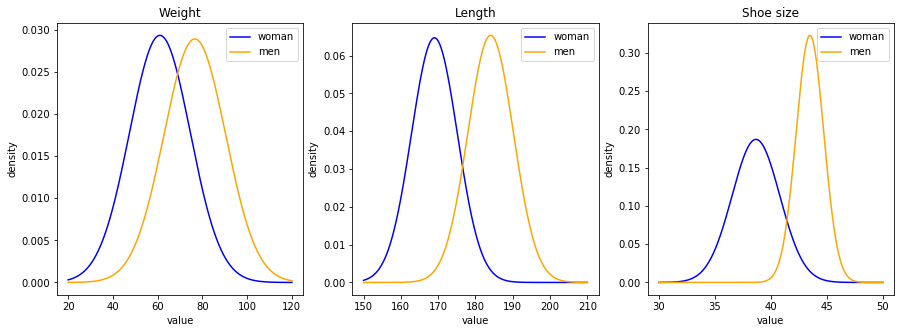

In [41]:
def fStdNormal(x):
    return 1/np.sqrt(2*np.pi) * np.exp( -x**2 / 2 )

def fNormal(x, mu, sigma):
    # define the normal distribution with mean mu and standard deviation sigma, use fStdNormal(x) defined above
    zscore = (x - mu) / sigma
    return fStdNormal(zscore) / sigma


x = np.linspace(0, 250, 1000)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    # solution below
    if (i == 0):
        x = np.linspace(20, 120, 1000)
    elif (i == 1):
        x = np.linspace(150, 210, 1000)
    else:
        x = np.linspace(30, 50, 1000)

    # use fnormal, and the meansF, stdsF, meansM, stdsM from estimated_pars
    woman_pdf = fNormal(x, estimated_pars[0,i], estimated_pars[1,i])
    ax[i].plot(x, woman_pdf, color='blue', label="woman")

    men_pdf = fNormal(x, estimated_pars[2,i], estimated_pars[3,i])
    ax[i].plot(x, men_pdf, color='orange', label="men")


    ax[i].set_title(['Weight', 'Length', 'Shoe size'][i])
    ax[i].set_xlabel('value')
    ax[i].set_ylabel('density')
    ax[i].legend()



plt.show()



### Defining the classifier

It is your task to complete the following function (**remember that for this data set you should NOT take the a priori probability of the two classes into consideration**):

In [42]:
def naive_bayes_classifier(w, l, s, meansF, stdsF, meansM, stdsM):
    """Return 1 in case the classifier decides the person with 
    weight=w, length=l and shoesize=s is a female, 0 otherwise"""

    pF = fNormal(w, meansF[0], stdsF[0]) * fNormal(l, meansF[1], stdsF[1]) * fNormal(s, meansF[2], stdsF[2])
    pM = fNormal(w, meansM[0], stdsM[0]) * fNormal(l, meansM[1], stdsM[1]) * fNormal(s, meansM[2], stdsM[2])
    if (pF > pM):
        return 1
    else:
        return 0


A nice Python trick is to unravel an iterable (tuple, list, array) into an argument list. Consider the following code:

In [43]:
p = estimate_parameters(X_bio, y_bio)
genders = ['male', 'female']
print(genders[naive_bayes_classifier(80, 180, 46, *p)])

male


In the above code, p is a tuple of all the values returned by estimateParameters, and with *p these values are unravelled into the last 4 arguments for the naiveBayesClassifier function. Be sure that the order of the variables is the same in both cases... In the code below this 'trick' is used twice:

### Testing the Classifier

For once we use the learning set to test the classifier. ***Really only this time!*** Feed your classifier with all (w,l,s) triples for all persons in the data set and test whether the outcome of the classifier corresponds with the true value. Present you results in the form of a confusion matrix. 

<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/downloads/confusionmatrix.png" width=50%>

So it is your task to calculate the 4 entries in the confusion matrix

     cfm = array( [[MasM, FasM], 
                   [MasF, FasF]] )

In [44]:
cfm = np.zeros((2,2))
for i in range(len(X_bio)):
    cfm[naive_bayes_classifier(*X_bio[i], *p), int(y_bio[i])] += 1

print(cfm.shape, cfm)

(2, 2) [[26.  1.]
 [ 1.  5.]]


### Calculating the A Posteriori Probability

The classifier as defined above is only capable of deciding $X=0$ or $X=1$. In many practical applications it is important to know how probable that classification really is. I.e. you would like to calculate the a posteriori probability $P(X=x\bigm|W=w,L=l,S=s)$ where $x$ is the classification result. Can you upgrade your classification function not only to return $x$ but also the a posteriori probability?

First rewrite the a posteriori probability into a form using only probabilities and probability densities that we are able to calculate

\begin{align}
P(X=x \bigm| W=w, L=l, S=s) &= \frac{P(W\approx w, L\approx l, S\approx s\bigm| X=x)P(X=x)}{P(W\approx w, L\approx l, S\approx s)}\\
&= \frac{P(W\approx w, L\approx l, S\approx s\bigm| X=x)P(X=x)}{
P(W\approx w, L\approx l, S\approx s\bigm| X=1)P(X=1) + P(W\approx w, L\approx l, S\approx s\bigm| X=0)P(X=0)}\\
&= \frac{f_{WLS|X=1}(w,l,s)P(X=x)}{f_{WLS|X=1}(w,l,s)P(X=1) + f_{WLS|X=0}(w,l,s)P(X=0)}
\end{align}


When implementing your formula for $P(X=x\bigm| W=w, L=w, S=s)$ again you should choose $P(X=1)=P(X=0)=0.5$.

In [45]:
def naive_bayes_classifier_prob(w, l, s, meansF, stdsF, meansM, stdsM):
    """Return a tuple (g, p) where g is the classification result (i.e. 1 in case the classifier decides the person with 
    weight=w, length=l and shoesize=s is a female, 0 otherwise) and p is the a posterio probability"""

    pF = fNormal(w, meansF[0], stdsF[0]) * fNormal(l, meansF[1], stdsF[1]) * fNormal(s, meansF[2], stdsF[2])
    pM = fNormal(w, meansM[0], stdsM[0]) * fNormal(l, meansM[1], stdsM[1]) * fNormal(s, meansM[2], stdsM[2])

    if (pF > pM):
        return (1, pF / (pF + pM))
    else:
        return (0, pM / (pF + pM))


Let's print out all classification results and their probability and observe that the two errors are made with great confidence... (showing of course our set of features is way too small to make a correct classification):

In [46]:
p = estimate_parameters(X_bio, y_bio)
for f, t in zip(X_bio, y_bio):
    g, prob = naive_bayes_classifier_prob(*f, *p)
    if t==g:
        label='correct'
    else:
        label='wrong'
    print(f, t, g, prob, label)

[ 60. 183.  42.] 0.0 0 0.9465445826257338 correct
[130. 185.  45.] 0.0 0 0.9999976068398813 correct
[ 84. 180.  42.] 0.0 0 0.9756245704232823 correct
[ 65. 195.  45.] 0.0 0 0.9999860895465281 correct
[ 55. 170.  42.] 0.0 1 0.9394868584304261 wrong
[ 63. 173.  41.] 1.0 1 0.9429488484604464 correct
[ 74. 185.  43.] 0.0 0 0.9982039836819794 correct
[ 50. 170.  38.] 1.0 1 0.9999985785056024 correct
[ 82. 180.  42.] 1.0 0 0.9712144742173608 wrong
[ 77. 190.  44.] 0.0 0 0.9999325274958734 correct
[ 76. 179.  43.] 0.0 0 0.983731092093668 correct
[ 66. 178.  42.] 0.0 0 0.7982347150239687 correct
[ 79. 186.  45.] 0.0 0 0.999851602646076 correct
[ 76. 189.  44.] 0.0 0 0.9998911547571083 correct
[ 75. 175.  42.] 0.0 0 0.7160242712476723 correct
[ 90. 190.  46.] 0.0 0 0.9999900874466343 correct
[ 70. 180.  41.] 0.0 0 0.6410594709841666 correct
[ 46. 164.  36.] 1.0 1 0.9999999999618033 correct
[ 98. 189.  44.] 0.0 0 0.9999835965276344 correct
[ 79. 180.  43.] 0.0 0 0.9914642408006165 correct
[ 67. 

It is a well known phenomenon that the naive Bayes classifier is quite good at classification, but not quite usable for estimating the a posteriori probabilities. In our data set the classifier was wrong in two cases, but the a posteriori probabilities are well over 90%.